# Activity: Build an XGBoost model

## Introduction

This activity builds on the skills and techniques learned in the decision tree and random forest lessons to construct a XGBoost classification model, a very powerful extension of decision tree. 

As a continuation of the airlines project in which the decision tree and random forest models were built, this time an XGBoost model will be trained, tuned, and evaluated. The performance of all three models will be compared and decided upon which model is the best. Finally, the feature importances will be explored to identify the ones that contribute most to customer satisfaction.


## Step 1: Imports

In [1]:
# Import relevant libraries and modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
import sklearn.metrics as metrics
from xgboost import XGBClassifier, plot_importance

pd.set_option('display.max_columns', None)

# This module lets us save our models once we fit them.
import pickle

### Load the dataset

Import a csv of airline passenger satisfaction data: `Invistico_Airline.csv`.

In [2]:
# IMPORT DATA. 
airline_data = pd.read_csv('Invistico_Airline.csv', error_bad_lines=False)

In [5]:
# Display the first ten rows of data.
airline_data.head(10)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,2,0,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,2,5,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,2,0,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,5,3,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,2,0,2,2,2,4,5,3,4,2,30,26.0


### Display the data type for each column

Observe the types of data present within this dataset.

In [6]:
# Display the data type for each column in the DataFrame.
airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj

**Question:** Identify the target (or predicted) variable for passenger satisfaction. What is your initial hypothesis about which variables will be valuable in predicting satisfaction?

- The `satisfaction` column from customer feedback will be used as target variable for binary classification task in the modeling objective to predict whether a passenger will be satisfied.
- Intuitively, as satisfactory of passenger is often correlated to the flight experience one has during travel, we may excl. `Customer Type`, `Age`, `Type of Travel`, `Class` & `Flight Distance` from the  predictor variables.  

Note: The variables might still be useful to examine how the model distributes its error across the different groups (eg. reported class / gender identities etc.) depending on the goal.

## Step 2: Model preparation

Before proceeding with building model, consider which metrics will ultimately be leveraged to evaluate the model.

**Question:** Which metrics are most suited to evaluating this type of model?
- Accuracy, Precision, Recall, and F1-score are among the most suited metrics for classification task, but the primary evaluation metric may depend on the costs of the measures taken to prevent an unsatisfactory customer versus the value of convincing them.

As we're unsure, we'll optimize model based on F1 score which balances the false positives & false negatives.     

### Prepare your data for predictions

When previewing the data that there are several non-numerical variables (`object` data types) within the dataset.

To prepare this DataFrame for modeling, first convert these variables into a numerical format.

In [3]:
# Convert the object predictor variables to numerical dummies.
airline_data = pd.get_dummies(airline_data, drop_first=True, columns=['satisfaction', 'Customer Type', 'Type of Travel', 'Class'])
airline_data

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction_satisfied,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,65,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0,1,0,1,1,0
1,47,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0,1,0,1,0,0
2,15,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0,1,0,1,1,0
3,60,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0,1,0,1,1,0
4,70,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,29,1731,5,5,5,3,2,5,2,2,3,3,4,4,4,2,0,0.0,1,1,1,1,0
129876,63,2087,2,3,2,4,2,1,1,3,2,3,3,1,2,1,174,172.0,0,1,1,0,0
129877,69,2320,3,0,3,3,3,2,2,4,4,3,4,2,3,2,155,163.0,0,1,1,1,0
129878,66,2450,3,2,3,2,3,2,2,3,3,2,3,2,1,2,193,205.0,0,1,1,1,0


In [4]:
airline_data.rename(columns={'satisfaction_satisfied': 'satisfaction', 
                             'Customer Type_disloyal Customer': 'Disloyal_Customer',
                             'Type of Travel_Personal Travel': 'Travel Obj'}, 
                    inplace=True)
airline_data.columns

Index(['Age', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction', 'Disloyal_Customer', 'Travel Obj', 'Class_Eco',
       'Class_Eco Plus'],
      dtype='object')

### Isolate your target and predictor variables
Separately define the target variable (`satisfaction`) and the features.

In [5]:
# Define the y (target) variable.
y = airline_data['satisfaction']

# Define the X (predictor) variables.
X = airline_data.drop('satisfaction', axis=1).copy()

Next, divide the data into a training set (75% of the data) and test set (25% of the data). This reserves a part of the data that the model has not seen for testing how well the model generalizes (or performs) on new data.

In [14]:
# Check the class ratio of target variable
y.value_counts(normalize=True)

1    0.547328
0    0.452672
Name: satisfaction, dtype: float64

In [15]:
# Perform the split operation on data.
# Assign the outputs as follows: X_train, X_test, y_train, y_test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Step 3: Model building

### "Instantiate" your XGBClassifer

Before you fit your model to your airline dataset, first create the XGB Classifier model and define its objective. You'll use this model to fit and score different hyperparameters during the GridSearch cross-validation process.

In [16]:
# Instantiate XGBClassifier.
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

### Define the parameters for hyperparameter tuning

To identify suitable parameters for `xgboost` model, first define the parameters for hyperparameter tuning. Specifically, a range of values for `max_depth`, `min_child_weight`, `learning_rate`, `n_estimators`, `subsample`, and `colsample_bytree`.

Consider a more limited range for each parameter to allow for timely iteration and model training.

In [17]:
# Define parameters for tuning as `cv_params`.
cv_params = {'max_depth': [2, 3, 4, 6],
             'min_child_weight': [1, 2, 4, 6],
             'learning_rate': [0.05, 0.1, 0.3],
             'n_estimators': [75, 100, 150]
            }

**Question:** What is the likely effect of adding more estimators to your GridSearch?

- Adding more estimators will likely to result in better model performance, but only to a certain extent as similar new trees will have diminishing returns and considerably increase the time spent during GridSearch process.  

### Define how the models will be evaluated

Define how the models will be evaluated for hyperparameter tuning. To yield the best understanding of model performance, utilize a suite of metrics.

In [19]:
# Define your criteria as `scoring`.
scoring = {'accuracy', 'precision', 'recall', 'f1'}

### Construct the GridSearch cross-validation 

Construct the GridSearch cross-validation using the model, parameters, and scoring metrics defined. Additionally, define the number of folds and specify *which metric* from above will guide the refit strategy.

In [21]:
# Construct your GridSearch.
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

### Fit the GridSearch model to your training data

If the GridSearch takes too long, revisit the parameter ranges above and consider narrowing the range and reducing the number of estimators.

In [22]:
%%time
# fit the GridSearch model to training data
xgb_cv.fit(X_train, y_train)

CPU times: user 1h 25min 21s, sys: 6.63 s, total: 1h 25min 28s
Wall time: 43min 11s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     predictor=None, random_state=0,
                                     reg_alpha=None, ...),
             iid='deprecated

**Question:** Which optimal set of parameters did the GridSearch yield?

In [23]:
xgb_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

### Save your model for reference using `pickle`

The `pickle` library can be used to save the output of this model for future retrieval w/o having to re-fit them everytime. 

In [24]:
# Use `pickle` to save the trained model.
path = '/home/jovyan/work'
with open(path + 'xgb_cv_model.pickle', 'wb') as xgb_modelobj:
    pickle.dump(xgb_cv, xgb_modelobj)

## Step 4: Results and evaluation

### Formulate predictions on test set

In [25]:
# Apply your model to predict on your test data. Call this output "y_pred".
y_pred = xgb_cv.predict(X_test)

### Leverage metrics to evaluate the model's performance

Leverage a series of metrics and evaluation techniques from scikit-learn by examining the actual observed values in the test set relative to the model's prediction.

In [27]:
# 1. Print your accuracy score.
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.3f}')

# 2. Print your precision score.
print(f'Precision: {metrics.precision_score(y_test, y_pred):.3f}')

# 3. Print your recall score.
print(f'Recall: {metrics.recall_score(y_test, y_pred):.3f}')

# 4. Print your f1 score.
print(f'F1: {metrics.f1_score(y_test, y_pred):.3f}')

Accuracy: 0.956
Precision: 0.967
Recall: 0.953
F1: 0.960


**Question:** How should the accuracy score be interpreted?

- Out of 32,470 collected feedbacks in the test set, the GBM model correctly predicted a high proportion of the customer satisfactory at 95.6%. 

**Question:** Is the accuracy score alone sufficient to evaluate the model?

- Often, accuracy is the most intuitive metric to evaluate the performance of a classification model but the metric alone is unable to tell the rate of false positive & false negative. 

**Question:** When observing the precision and recall scores of the model, how should these values be interpreted, and is one more accurate than the other?

- The precision of the model is slightly higher than the recall, which means that the model is better at predicting the False Positive than False Negative value. 

**Question:** What does the model's F1 score tell beyond what the other metrics provide?*

- The F1 score indicates that how well the model balances the no. of false positive & false negative values when delivering predictions. In this case, F1 score=0.96 suggests very strong predictive power in this model.  

### Gain clarity with the confusion matrix

Recall that a **confusion matrix** is a graphic that shows a model's true and false positives and true and false negatives. It helps to create a visual representation of the components feeding into the metrics above.

In [28]:
# Construct and display your confusion matrix.
def conf_matrix_plot(clf_model, x_data, y_data): 
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    '''
 
    y_pred = clf_model.predict(x_data)
    cm = metrics.confusion_matrix(y_data, y_pred, labels=clf_model.classes_)  # for multinomial, use `multilabel_confusion_matrix`
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_model.classes_)
    
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation / alter str formatting
    plt.show()


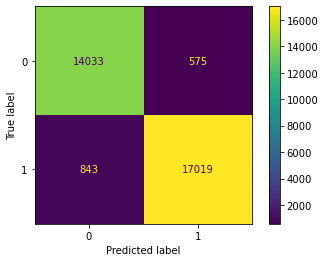

In [29]:
conf_matrix_plot(xgb_cv, X_test, y_test)

**Question:** what do you notice? Does this correlate to any of your other calculations?

- The confusion matrix indicates that, when the model makes an error, it's usually a Type II error—it gives a false negative by incentivizing many unnecessary treatment where the satisfied customers are misclassified. On the other hand, it makes comparatively fewer Type I errors, which are false positives.      

### Visualize most important features

`xgboost` has a built-in function to visualize the relative importance of the features in the model using `matplotlib`. Output and examine the feature importance of model.

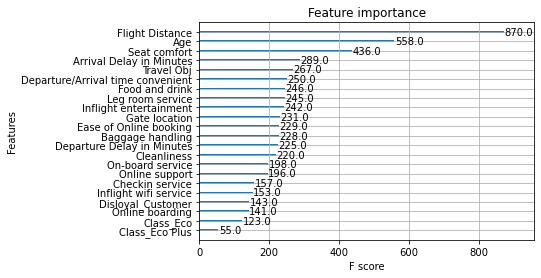

In [30]:
# Plot the relative feature importance of the predictor variables in model.
plot_importance(xgb_cv.best_estimator_)

**Question:** Examine the feature importances outputted above. What is your assessment of the result? Did anything surprise you?

- The plot illuminates the most important features used by the model, such as `Flight Distance`, `Age`, and `Seat comfort`.  

### Compare models

Create a table of results to compare model performance.

In [8]:
# Create a table of results to compare model performance.
table = pd.DataFrame({'Model': ["Tuned Decision Tree", "Tuned Random Forest", "Tuned XGBoost"],
                      'F1': [0.944983, 0.957379, 0.960],
                      'Recall': [0.938271, 0.966525, 0.953],
                      'Precision': [0.951796, 0.948403, 0.967],
                      'Accuracy': [0.940205, 0.953742, 0.956]
                     }
                    )
table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.944983,0.938271,0.951796,0.940205
1,Tuned Random Forest,0.957379,0.966525,0.948403,0.953742
2,Tuned XGBoost,0.960000,0.953000,0.967000,0.956000


**Question:** How does this model compare to the decision tree and random forest models that is built in previous labs? 

Based on the results, the F1, precision, recall and accuracy scores of the XGBoost model are at overall better than the corresponding scores of the decision tree & random forest by a slight margin.  

## Considerations

**How would you share your findings with your team?**

- Showcase the data used to create the prediction and the performance of the model overall.
- Review the sample output of the features and the confusion matrix to reference the model's performance.
- Highlight the metric values, emphasizing the F1 score.
- Visualize the feature importance to showcase what drove the model's predictions.

**What would you share with and recommend to stakeholders?**

- The model created is highly effective at predicting passenger satisfaction.
- The feature importances of flight distance, age, and seat comfort warrant additional investigation, at which particular groups from age & flight distance have some undisputing disagreement on the sactisfactory of travel. It will be important to ask domain experts why they believe this feature scores so highly in this model.
